In [1]:
# imports
import os
import re
import math
import random
import collections
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers
 
#from keras.utils import plot_model
print("Keras backend : ", keras.backend.backend())

Using TensorFlow backend.


Keras backend :  tensorflow


In [2]:
#key variables
languages_dict = {'en' : 0, 'fr' : 1, 'es' : 2, 'it' : 3, 'de' : 4, 'sk' : 5, 'cs' : 6}

text_sample_size = 140
num_lang_samples = 250000

def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

def decode_langid(langid):
    for dname, did in languages_dict.items():
        if did == langid:
            return dname
def define_alphabet():
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    special_chars = ' !?¿¡'
    german = 'äöüß'
    italian = 'àèéìíòóùú'
    french = 'àâæçéèêêîïôœùûüÿ'
    spanish = 'áéíóúüñ'
    czech = 'áčďéěíjňóřšťúůýž'
    slovak = 'áäčďdzdžéíĺľňóôŕšťúýž'
    all_lang_chars = base_en + german +  italian + french + spanish + czech + slovak
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    small_chars += special_chars
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
    return small_chars,big_chars,letters_string

alphabet = define_alphabet()
print (alphabet)

(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž', ' ', '!', '?', '¿', '¡'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž'], 'abcdefghijklmnopqrstuvwxyzßàáâäæçèéêìíîïñòóôöùúûüýÿčďěĺľňœŕřšťůž !?¿¡ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÂÄÆÇÈÉÊÌÍÎÏÑÒÓÔÖÙÚÛÜÝČĎĚĹĽŇŒŔŘŠŤŮŸŽ')


In [3]:
# this function will get sample of texh from each cleaned language file. 
# It will try to preserve complete words - if word is to be sliced, sample will be shortened to full word
def get_sample_text(file_content,start_index,sample_size):
    # we want to start from full first word
    # if the firts character is not space, move to next ones
    while not (file_content[start_index].isspace()):
        start_index += 1
    #now we look for first non-space character - beginning of any word
    while file_content[start_index].isspace():
        start_index += 1
    end_index = start_index+sample_size 
    # we also want full words at the end
    while not (file_content[end_index].isspace()):
        end_index -= 1
    return file_content[start_index:end_index]

# we need only alpha characters and some (very limited) special characters
# exactly the ones defined in the alphabet
# no numbers, most of special characters also bring no value for our classification task
# (like dot or comma - they are the same in all of our languages so does not bring additional informational value)

# count number of chars in text based on given alphabet
def count_chars(text,alphabet):
    alphabet_counts = []
    for letter in alphabet:
        count = text.count(letter)
        alphabet_counts.append(count)
    return alphabet_counts

# process text and return sample input row for DNN
# note that we are counting separatey:
# a) counts of all letters regardless of their size (whole text turned to lowercase letter)
# b) counts of big letters only
# this is because German uses big letters for beginning of nouns so this feature is meaningful
def get_input_row(content,start_index,sample_size):
    sample_text = get_sample_text(content,start_index,sample_size)
    counted_chars_all = count_chars(sample_text.lower(),alphabet[0])
    counted_chars_big = count_chars(sample_text,alphabet[1])
    all_parts = counted_chars_all + counted_chars_big
    return all_parts
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained

path = os.path.join("./Data/cleaned_data/", "de_cleaned.txt")
with open(path, 'r', encoding = "UTF-8") as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*text_sample_size)
    sample_text = get_sample_text(content,random_index,text_sample_size)
    print ("1. Sample text: \n",sample_text)
    print ("2. Reference alphabet: \n",alphabet[0],alphabet[1])
    sample_input_row = get_input_row(content,random_index,text_sample_size)
    print ("3. Sample_input_row: \n",sample_input_row)
    input_size = len(sample_input_row)
    print ("4. Input size : ", input_size)
    del content

1. Sample text: 
 sind das Bulgarien, Zypern, die Tschechische Republik, Estland, Griechenland, Ungarn, Lettland, Litauen, Malta, Polen, Rumänien und die
2. Reference alphabet: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž', ' ', '!', '?', '¿', '¡'] ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž']
3. Sample_input_row: 
 [9, 2, 4, 8, 14, 0, 3, 4, 9, 0, 1, 9, 2, 14, 1, 3, 0, 6, 5, 6, 6, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
# now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((num_lang_samples*len(languages_dict),input_size+1),dtype = np.uint16)
lang_seq = 0
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
for lang_code in languages_dict:
    start_index = 0
    path = os.path.join("./Data/cleaned_data/", lang_code+"_cleaned.txt")
    with open(path, 'r', encoding = "UTF-8") as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - text_sample_size*num_lang_samples
        jump = int(((remaining/num_lang_samples)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/input_size),\
              "| # skip chars : " + str(jump))
        for idx in range(num_lang_samples):
            input_row = get_input_row(file_content,start_index,text_sample_size)
            sample_data[num_lang_samples*lang_seq+idx,] = input_row + [languages_dict[lang_code]]
            start_index += text_sample_size + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# let's randomy shuffle the data
np.random.shuffle(sample_data)
# reference input size
print ("Input size : ",input_size )
print (100*"-")
print ("Samples array size : ",sample_data.shape )
path_smpl = os.path.join("./Data/samples_directory/","lang_samples_"+str(input_size)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "size : ",size_mb(os.path.getsize(path_smpl)))
del sample_data

Processing file : ./Data/cleaned_data/fr_cleaned.txt
File size :  361.89 MB  | # possible samples :  2741567 | # skip chars : 980
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned_data/de_cleaned.txt
File size :  350.31 MB  | # possible samples :  2653886 | # skip chars : 945
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned_data/cs_cleaned.txt
File size :  89.18 MB  | # possible samples :  675632 | # skip chars : 162
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned_data/it_cleaned.txt
File size :  349.81 MB  | # possible samples :  2650106 | # skip chars : 944
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned_data/en_cleaned.txt
File size :  331.35 MB  |

In [5]:
path_smpl = os.path.join("./Data/samples_directory/","lang_samples_"+str(input_size)+".npz")
dt = np.load(path_smpl)['data']
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("Sample language : ",decode_langid(dt[random_index,][input_size]))
# we can also check if the data have equal share of different languages
print ("Dataset shape :", dt.shape)
bins = np.bincount(dt[:,input_size])
print ("Language bins count : ") 
for lang_code in languages_dict: 
    print (lang_code,bins[languages_dict[lang_code]])

Sample record : 
 [ 4  0  2  5  7  1  0  3  5  1  4  0  8  6  7  8  0  4  2  6  3  6  0  0  0
  4  0  0  7  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  2
  0  0  0  3  0  0  1  0  0  4  1  0  1  0 19  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6]
Sample language :  cs
Dataset shape : (1750000, 133)
Language bins count : 
fr 250000
de 250000
cs 250000
it 250000
en 250000
es 250000
sk 250000


In [6]:
# we need to preprocess data for DNN yet again - scale it 
# scling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
from keras.utils import np_utils
dt = dt.astype(np.float64)
# X and Y split
X = dt[:,0:input_size]
Y = dt[:,input_size]
del dt
# random index to check random sample
random_index = random.randrange(0,X.shape[0])
print("Example data before processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])
Y = np_utils.to_categorical(Y, len(languages_dict))
#time.sleep(120) # sleep time to allow release memory. This step is very memory consuming
# X preprocessing
# standar scaler will be useful laterm during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   
print ("X preprocessed shape :", X.shape)
# Y one-hot encoding

# See the sample data
print("Example data after processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])
# train/test split. Static seed to have comparable results for different runs
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)
del X, Y
# wait for memory release again
#time.sleep(120)
# save train/test arrays to file 
path_tt = os.path.join("./Data/train_test/"+"train_test_data_"+str(input_size)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))
del X_train,Y_train,X_test,Y_test

Example data before processing:
X : 
 [  7.   2.   3.   3.  10.   1.   0.   0.   5.   2.   3.   6.   2.   7.   8.
   4.   0.   3.   4.   6.   2.   5.   0.   0.   2.   3.   0.   0.   2.   0.
   0.   0.   0.   0.   1.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   2.   0.   0.   0.   0.   0.   3.
   2.   0.   1.   4.  20.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Y : 
 6.0
X preprocessed shape : (1750000, 132)
Example data after processing:
X : 
 [ -5.09504302e-01   3.78326824e-01  -3.18554419e-01  -6.92028485e-01
  -8.43996694e-01  -8.33352963e-02  -9.05245499e-01  -1.06145183e+00
  -9.32047189e-01   8.90224141e-01   8.40560431e-01   4.81509525e-01


In [7]:
# load train data first from file
path_tt = os.path.join("./Data/train_test/","train_test_data_"+str(input_size)+".npz")
train_test_data = np.load(path_tt)
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)
X_test = train_test_data['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data['Y_test']
print ("Y_test: ",Y_test.shape)
del train_test_data

X_train:  (1400000, 132)
Y_train:  (1400000, 7)
X_test:  (350000, 132)
Y_test:  (350000, 7)


In [8]:
# create DNN using Keras Sequential API
# I added Dropout to prevent overfitting
print(input_size)
model = Sequential()
model.add(Dense(500,input_dim=input_size,init="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300,init="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100,init="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(languages_dict),init="glorot_uniform",activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

132


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="sigmoid", kernel_initializer="glorot_uniform", input_dim=132)`
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="sigmoid", kernel_initializer="glorot_uniform")`
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="sigmoid", kernel_initializer="glorot_uniform")`
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(7, activation="softmax", kernel_initializer="glorot_uniform")`


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               66500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total para

In [10]:
# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
          nb_epoch=12,
          validation_split=0.10,
          batch_size=64,
          verbose=2,
          shuffle=True)

D:\Anaconda\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1260000 samples, validate on 140000 samples
Epoch 1/12
 - 330s - loss: 0.0503 - acc: 0.9842 - val_loss: 0.0207 - val_acc: 0.9933
Epoch 2/12
 - 225s - loss: 0.0263 - acc: 0.9921 - val_loss: 0.0199 - val_acc: 0.9936
Epoch 3/12
 - 226s - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0183 - val_acc: 0.9943
Epoch 4/12
 - 235s - loss: 0.0233 - acc: 0.9931 - val_loss: 0.0186 - val_acc: 0.9945
Epoch 5/12
 - 248s - loss: 0.0227 - acc: 0.9933 - val_loss: 0.0181 - val_acc: 0.9944
Epoch 6/12
 - 228s - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0180 - val_acc: 0.9947
Epoch 7/12
 - 238s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0174 - val_acc: 0.9945
Epoch 8/12
 - 238s - loss: 0.0213 - acc: 0.9938 - val_loss: 0.0180 - val_acc: 0.9947
Epoch 9/12
 - 250s - loss: 0.0213 - acc: 0.9939 - val_loss: 0.0169 - val_acc: 0.9948
Epoch 10/12
 - 247s - loss: 0.0210 - acc: 0.9939 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 11/12
 - 250s - loss: 0.0214 - acc: 0.9940 - val_loss: 0.0173 - val_acc: 0.9948
Epoch 12/1

In [11]:
# now we will face the TRUTH. What is our model real accuracy tested on unseen data?
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

350000/350000 [==============================] - 40s 116us/step
acc: 99.48%


In [12]:
# and now we will prepare data for scikit-learn classification report
Y_pred = model.predict_classes(X_test)
Y_pred = np_utils.to_categorical(Y_pred, len(languages_dict))

In [13]:
# and run the report
target_names =  list(languages_dict.keys())
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

         fr       0.99      1.00      1.00     49967
         de       1.00      0.99      0.99     50143
         cs       0.99      0.99      0.99     50090
         it       0.99      0.99      0.99     50116
         en       1.00      1.00      1.00     49823
         es       0.99      1.00      1.00     50006
         sk       1.00      0.99      1.00     49855

avg / total       0.99      0.99      0.99    350000



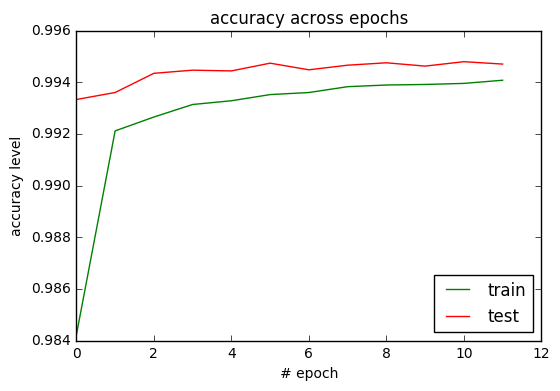

In [14]:
# show plot accuracy changes during training
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

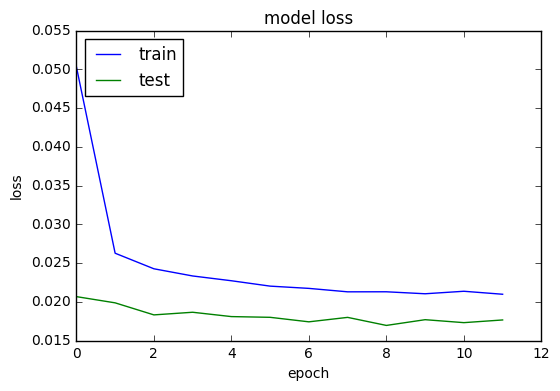

In [15]:
# show plot of loss changes during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# and now we will have some fun. Seeing is believing!
# We will take some texts and try to predict the text's language using our trained neural network.

# Frank Baum, The Wonderful Wizard of Oz, Project Gutenberg, public domain
en_text = "You are welcome, most noble Sorceress, to the land of the Munchkins. We are so grateful to you \
for having killed the Wicked Witch of the East, and for setting our people free from bondage."
# Johann Wolfgang von Goethe, Faust: Der Tragödie erster Teil, Project Gutenberg, public domain
de_text = "Habe nun, ach! Philosophie, Juristerei und Medizin, Und leider auch Theologie \
Durchaus studiert, mit heißem Bemühn. Da steh ich nun, ich armer Tor! Und bin so klug als wie zuvor;"
# Pierre Benoît, L'Atlantide, 
fr_text = "Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et \
goûtais fort cette indépendance. Je puis même affirmer, sans me flatter"
# Alberto Boccardi, Il peccato di Loreta, Project Gutenberg, public domain
it_text = "Giovanni Sant'Angelo, che negli anni passati a Padova in mezzo alla baraonda tanto gioconda degli studenti,\
aveva appreso ad amare con foga di giovane qualche alto ideale, tornato in famiglia dovette fare uno sforzo"
# Fernando Callejo Ferrer, Música y Músicos Portorriqueños, Project Gutenberg, public domain
es_text = "Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros \
comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición"
# František Omelka, Blesky nad Beskydami, Project Gutenberg, public domain
cs_text = "A Slávek, jsa povzbuzen, se ptal a otec odpovídal. Přestože byl prostým venkovským listonošem,\
nepřivedla jej žádná synova otázka do rozpaků. Od mládí se zajímal o dějepis a literaturu."
# Janko Matúška, Nad Tatrou sa blýska,  national anthem of Slovakia, https://en.wikipedia.org/wiki/Nad_Tatrou_sa_blýska
sk_text = "Nad Tatrou1 sa blýska Hromy divo bijú Zastavme ich, bratia Veď sa ony stratia Slováci ožijú \
To Slovensko naše Posiaľ tvrdo spalo Ale blesky hromu Vzbudzujú ho k tomu Aby sa prebralo"

text_texts_array = [en_text,de_text,fr_text,it_text,es_text,cs_text,sk_text]
test_array = []
for item in text_texts_array:
    #cleaned_text = clean_text(item)
    input_row = get_input_row(item,0,text_sample_size)
    test_array.append(input_row)

test_array = standard_scaler.transform(test_array)     
Y_pred = model.predict_classes(test_array)
for id in range(len(test_array)):
    print ("Text:",text_texts_array[id][:50],"... -> Predicted lang: ", decode_langid(Y_pred[id]))

Text: You are welcome, most noble Sorceress, to the land ... -> Predicted lang:  en
Text: Habe nun, ach! Philosophie, Juristerei und Medizin ... -> Predicted lang:  de
Text: Voilà cinq mois que j'en faisais fonction, et, ma  ... -> Predicted lang:  fr
Text: Giovanni Sant'Angelo, che negli anni passati a Pad ... -> Predicted lang:  it
Text: Dedicada esta sección a la reseña de los composito ... -> Predicted lang:  es
Text: A Slávek, jsa povzbuzen, se ptal a otec odpovídal. ... -> Predicted lang:  cs
Text: Nad Tatrou1 sa blýska Hromy divo bijú Zastavme ich ... -> Predicted lang:  sk
